Changelog:  (Last Updated 2024-03-04)

*



# Probabilistic ML: Assignment 3 (start early!)
- **Submission**: You need to submit your solutions through Crowdmark, including all your derivations, plots, and your code. You can produce the files however you like (e.g. $\LaTeX$, Microsoft Word, etc), as long as it is readable. Points will be deducted if we have a hard time reading your solutions or understanding the structure of your code.
- **Collaboration policy**: After attempting the problems on an individual basis, you may discuss and work together on the assignment with up to two classmates. However, **you must write your own code and write up your own solutions individually and explicitly name any collaborators** at the top of the homework.

# 1. [50pts] Stochastic Variational Inference in the TrueSkill Model

## Background

We'll continue working with [TrueSkill](http://papers.nips.cc/paper/3079-trueskilltm-a-bayesian-skill-rating-system.pdf) model, a player ranking system for competitive games originally developed for Halo 2. Recall the model:


## Model definition

We assume that each player has a true, but unknown skill $z_i \in \mathbb{R}$.
We use $N$ to denote the number of players.

### The prior:
The prior over each player's skill is a standard normal distribution, and all player's skills are *a priori* independent.

### The likelihood:
For each observed game, the probability that player $A$ beats player $B$, given the player's skills $z_A$ and $z_B$, is:
$$p(A \,\, \text{beat} \,\, B | z_A, z_B) = \sigma(z_A - z_B)$$
where
$$\sigma(y) = \frac{1}{1 + \exp(-y)}$$
We chose this function simply because it's close to zero or one when the player's skills are very different, and equals one-half when the player skills are the same.  This likelihood function is the only thing that gives meaning to the latent skill variables $z_1 \dots z_N$.

There can be more than one game played between a pair of players. The outcome of each game is independent, given the players' skills.
We use $M$ to denote the number of games.


In [ ]:
!pip install wget
import os
import os.path

import matplotlib.pyplot as plt
import wget

import pandas as pd


import numpy as np
from scipy.stats import norm
import scipy.io
import scipy.stats
import torch
import random
from torch import nn
from torch.distributions.normal import Normal

from functools import partial
from tqdm import trange, tqdm_notebook

import matplotlib.pyplot as plt

# Helper function
def diag_gaussian_log_density(x, mu, std):
    # axis=-1 means sum over the last dimension.
    m = Normal(mu, std)
    return torch.sum(m.log_prob(x), axis=-1)

## Implementing the TrueSkill Model



This part was mostly done in Assignment 2. We will recall some useful functions.

**a)** The function $\texttt{log_joint_prior}$ computes the log of the prior, jointly evaluated over all player's skills.

In [ ]:
def log_joint_prior(zs_array):
    return diag_gaussian_log_density(zs_array, torch.tensor([0.0]), torch.tensor([1.0]))

**b)** The function `logp_a_beats_b`, given a pair of skills $z_a$ and $z_b$, evaluates the log-likelihood that player with skill $z_a$ beat player with skill $z_b$ under the model detailed above.

To ensure numerical stability, we use the function `np.log1p` that computes $\log(1 + x)$ in a numerically stable way.  Or even better, use `np.logaddexp`.

In [ ]:
def logp_a_beats_b(z_a, z_b):
    return -torch.logaddexp(torch.tensor([0.0]), z_b - z_a)

def log_prior_over_2_players(z1, z2):
    m = Normal(torch.tensor([0.0]), torch.tensor([[1.0]]))
    return m.log_prob(z1) + m.log_prob(z2)

def prior_over_2_players(z1, z2):
    return torch.exp(log_prior_over_2_players(z1, z2))

def log_posterior_A_beat_B(z1, z2):
    return log_prior_over_2_players(z1, z2) + logp_a_beats_b(z1, z2)

def posterior_A_beat_B(z1, z2):
    return torch.exp(log_posterior_A_beat_B(z1, z2))

def log_posterior_A_beat_B_10_times(z1, z2):
    return log_prior_over_2_players(z1, z2) + 10.0 * logp_a_beats_b(z1, z2)

def posterior_A_beat_B_10_times(z1, z2):
    return torch.exp(log_posterior_A_beat_B_10_times(z1, z2))

def log_posterior_beat_each_other_10_times(z1, z2):
    return log_prior_over_2_players(z1, z2) \
        + 10.* logp_a_beats_b(z1, z2) \
        + 10.* logp_a_beats_b(z2, z1)

def posterior_beat_each_other_10_times(z1, z2):
    return torch.exp(log_posterior_beat_each_other_10_times(z1, z2))

The following functions will be used for plotting.  Note that `plot_2d_fun` can now take an optional second function, so you can compare two functions.

In [ ]:
# Plotting helper functions for free
def plot_isocontours(ax, func, xlimits=[-4, 4], ylimits=[-4, 4], steps=101, cmap="summer"):
    x = torch.linspace(*xlimits, steps=steps)
    y = torch.linspace(*ylimits, steps=steps)
    X, Y = torch.meshgrid(x, y)
    Z = func(X, Y)
    plt.contour(X, Y, Z, cmap=cmap)
    ax.set_yticks([])
    ax.set_xticks([])

def plot_2d_fun(f, x_axis_label="", y_axis_label="", f2=None, scatter_pts=None):
    # This is the function your code should call.
    # f() should take two arguments.
    fig = plt.figure(figsize=(8,8), facecolor='white')
    ax = fig.add_subplot(111, frameon=False)
    ax.set_xlabel(x_axis_label)
    ax.set_ylabel(y_axis_label)
    plot_isocontours(ax, f)
    if f2 is not None:
      plot_isocontours(ax, f2, cmap='winter')

    if scatter_pts is not None:
      plt.scatter(scatter_pts[:,0], scatter_pts[:, 1])
    plt.plot([4, -4], [4, -4], 'b--')   # Line of equal skill
    plt.show(block=True)
    plt.draw()

## **1.1 [20pts]** Stochastic Variational Inference on Two Players and Toy Data

One nice thing about a Bayesian approach is that it separates the model specification from the approximate inference strategy.
The original Trueskill paper from 2007 used message passing.

In this question we will  approximate posterior distributions with gradient-based stochastic variational inference.

The parameters are $\phi = (\mu,\log(\sigma))$. Notice that instead of $\sigma$ (which is constrained to be positive), we work with $\log(\sigma)$, removing the constraint. This way, we can do unconstrained gradient-based optimization.



**a) [10pts]** Implement the missing lines in the code below, to complete the evidence lower bound function and the reparameterized sampler for the approximate posterior.

Hint 1: You must use the reparametrization trick in your sampler if you want your gradients to be unbiased.

Hint 2: If you're worried you got these wrong, you can check that the sampler matches the log pdf by plotting a histogram of samples against a plot of the pdf.

In [ ]:
def diag_gaussian_samples(mean, log_std, num_samples):
    # mean and log_std are (D) dimensional vectors
    # Return a (num_samples, D) matrix, where each sample is
    # from a diagonal multivariate Gaussian.

    # TODO.  You might want to use torch.randn(). Remember
    # you must use the reparameterization trick.  Also remember that
    # we are parameterizing the _log_ of the standard deviation.
    epsilon = torch.randn(num_samples, mean.shape[0])
    samples = mean + torch.exp(log_std) * epsilon
    return samples

import math
def diag_gaussian_logpdf(x, mean, log_std):
    # Evaluate the density of a batch of points on a
    # diagonal multivariate Gaussian. x is a (num_samples, D) matrix.
    # Return a tensor of shape (num_samples)

    # std = torch.exp(log_std)
    # D = mean.shape[0]
    # log_density = -0.5 * D * math.log(2 * math.pi) - torch.sum(log_std) - 0.5 * torch.sum(((x - mean) / std) ** 2, dim=1)
    # return log_density

    return torch.sum(Normal(mean, torch.exp(log_std)).log_prob(x), axis=-1)

def batch_elbo(logprob, mean, log_std, num_samples):
    # TODO: Use simple Monte Carlo to estimate ELBO
    # on a batch of size num_samples
    samples = diag_gaussian_samples(mean, log_std, num_samples)
    log_variational_density = diag_gaussian_logpdf(samples, mean, log_std)
    log_density_samples = logprob(samples)
    elbo_estimate = torch.mean(log_density_samples - log_variational_density)

    return elbo_estimate


**b) [4pts]** Write a loss function called $\texttt{objective}$  that takes variational distribution parameters, and returns an unbiased estimate of the negative elbo using $\texttt{num_samples_per_iter}$ samples, to approximate the joint posterior over skills conditioned on observing player A winning 10 games.

Note: We want a _negative_ ELBO estimate, because the convention in optimization is to minimize functions, and we want to maximize the ELBO.

In [ ]:
# Hyperparameters
num_players = 2
n_iters = 800
stepsize = 0.0001
num_samples_per_iter = 50

def log_posterior_A_beat_B_10_times_1_arg(z1z2):
  return log_posterior_A_beat_B_10_times(z1z2[:,0], z1z2[:,1])

def objective(params):  # The loss function to be minimized.
  # TODO.  Hint:  This can be done in one line.
  mean, log_std = params
  return -batch_elbo(log_posterior_A_beat_B_10_times_1_arg, mean, log_std, num_samples_per_iter)

**c) [2pts]** Initialize a set of variational parameters and optimize them (written for you already) to approximate the joint distribution where we observe player A winning 10 games. Report the final loss. Also plot the optimized variational approximation contours and the target distribution on the same axes.

Hint:  Any initialization should be fine.  How many variational parameters do you need?

Optimizing variational parameters...


  4%|▍         | 33/800 [00:00<00:02, 322.71it/s]

Iteration 0 lower bound 9.093286514282227
Iteration 25 lower bound 7.74151611328125
Iteration 50 lower bound 6.579061508178711


  9%|▉         | 72/800 [00:00<00:02, 358.94it/s]

Iteration 75 lower bound 6.794504165649414
Iteration 100 lower bound 6.119106292724609


 20%|██        | 162/800 [00:00<00:02, 225.90it/s]

Iteration 125 lower bound 4.774386405944824
Iteration 150 lower bound 5.0106000900268555


 26%|██▌       | 209/800 [00:00<00:02, 201.05it/s]

Iteration 175 lower bound 4.101808547973633
Iteration 200 lower bound 3.8674685955047607


 32%|███▎      | 260/800 [00:01<00:02, 221.94it/s]

Iteration 225 lower bound 3.383028268814087
Iteration 250 lower bound 3.476841926574707
Iteration 275 lower bound 3.611187696456909


 44%|████▍     | 353/800 [00:01<00:01, 280.02it/s]

Iteration 300 lower bound 3.341916084289551
Iteration 325 lower bound 3.4883551597595215
Iteration 350 lower bound 3.1381945610046387


 56%|█████▌    | 444/800 [00:01<00:00, 372.41it/s]

Iteration 375 lower bound 3.247271776199341
Iteration 400 lower bound 3.5055320262908936
Iteration 425 lower bound 3.8367998600006104
Iteration 450 lower bound 2.964752435684204
Iteration 475 lower bound 3.4495041370391846


 67%|██████▋   | 535/800 [00:01<00:00, 371.86it/s]

Iteration 500 lower bound 3.024139642715454
Iteration 525 lower bound 3.0008370876312256
Iteration 550 lower bound 3.1031441688537598


 77%|███████▋  | 615/800 [00:02<00:00, 373.14it/s]

Iteration 575 lower bound 3.0588762760162354
Iteration 600 lower bound 2.933098793029785
Iteration 625 lower bound 3.1376993656158447
Iteration 650 lower bound 3.0385231971740723


 97%|█████████▋| 773/800 [00:02<00:00, 473.88it/s]

Iteration 675 lower bound 2.874427556991577
Iteration 700 lower bound 3.0495522022247314
Iteration 725 lower bound 2.9720299243927
Iteration 750 lower bound 2.904787063598633
Iteration 775 lower bound 2.96894907951355


100%|██████████| 800/800 [00:02<00:00, 324.30it/s]


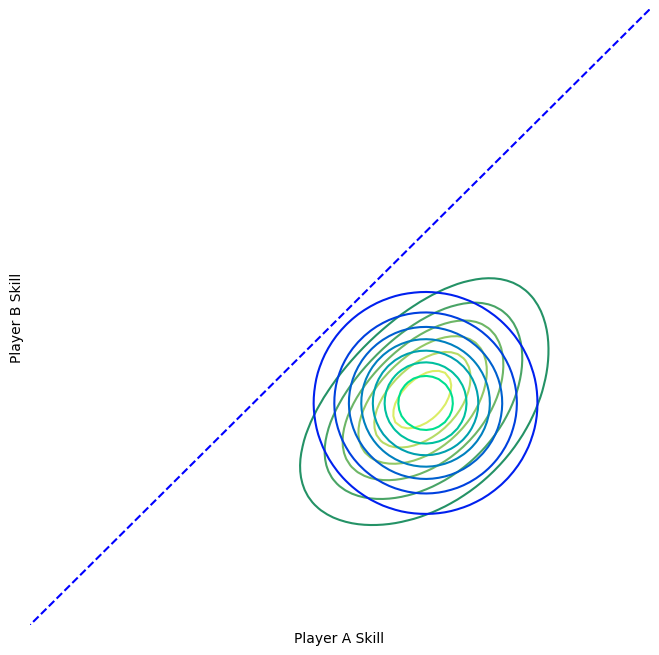

<Figure size 640x480 with 0 Axes>

In [ ]:
def callback(params, t):
  if t % 25 == 0:
    print("Iteration {} lower bound {}".format(t, objective(params)))

# Set up optimizer.
D = 2
init_log_std  = torch.tensor([0.0, 0.0], requires_grad=True) # TODO.
init_mean = torch.tensor([0.0, 0.0], requires_grad=True)# TODO

params = [init_mean, init_log_std]
optimizer = torch.optim.SGD(params, lr=stepsize, momentum=0.9)

def update():
    optimizer.zero_grad()
    loss = objective(params)
    loss.backward()
    optimizer.step()

# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(params, t)


def approx_posterior_2d(z1, z2):
    # The approximate posterior
    mean, logstd = params[0].detach(), params[1].detach()
    zs = torch.stack([z1.flatten(), z2.flatten()], dim=1)
    probs = torch.exp(diag_gaussian_logpdf(zs, mean, logstd))
    return probs.view(z1.shape)

plot_2d_fun(posterior_A_beat_B_10_times, "Player A Skill", "Player B Skill",
            f2=approx_posterior_2d)

**d) [2pts]** Write a loss function called $\texttt{objective}$  that takes the variational distribution parameters, and returns a negative ELBO estimate using simple Monte Carlo with $\texttt{num_samples_per_iter}$ samples, to approximate the joint distribution where we observe player A winning 10 games and player B winning 10 games.

Hint:  You can find analogous functions in the code above.


In [ ]:
# Hyperparameters
n_iters = 100
stepsize = 0.0001
num_samples_per_iter = 50

def log_posterior_beat_each_other_10_times_1_arg(z1z2):
    # z1z2 is a tensor with shape (num_samples x 2)
    # Return a tensor with shape (num_samples)
    return log_posterior_A_beat_B_10_times(z1z2[:,0], z1z2[:,1])

def objective(params):
    mean, log_std = params

    samples = diag_gaussian_samples(mean, log_std, num_samples_per_iter)
    log_probs = log_posterior_beat_each_other_10_times_1_arg(samples)

    return -torch.mean(log_probs)

**e) [2pts]** Run the code below to optimize the parameters, and report the final loss. Also plot the optimized variational approximation contours and the target distribution on the same axes.

---

Write one or two sentences describing the joint settings of skills that are plausible under the true posterior, but which are not plausible under the approximate posterior.

---

Finally, answer with one or two sentences:  Would changing the variational approximate posterior from a fully-factorized (diagonal covariance) Gaussian to a non-factorized (fully parameterized covariance) Gaussian make a better approximation in this instance?

Optimizing variational parameters...


 46%|████▌     | 46/100 [00:00<00:00, 459.53it/s]

Iteration 0 lower bound 12.212924003601074
Iteration 25 lower bound 10.566967010498047
Iteration 50 lower bound 11.287104606628418
Iteration 75 lower bound 8.895169258117676


100%|██████████| 100/100 [00:00<00:00, 403.91it/s]


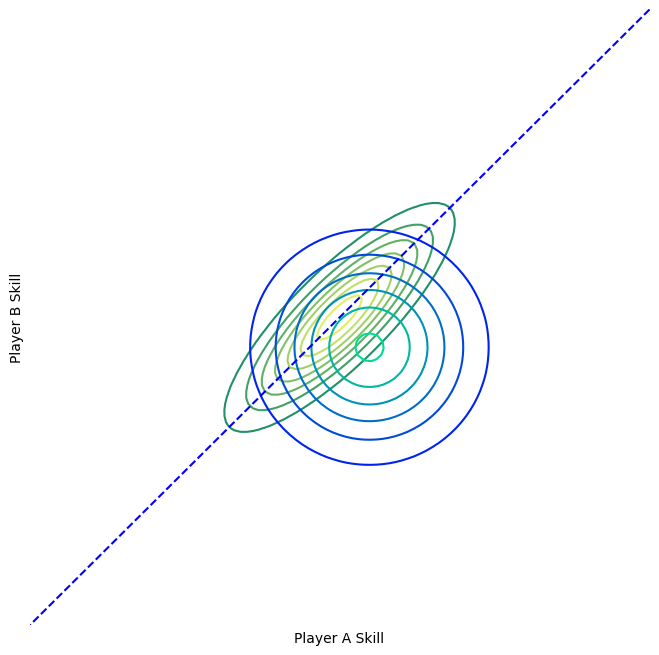

<Figure size 640x480 with 0 Axes>

In [ ]:
# Main loop.
# Reinitialize with the same initialization as you did in 1c) .
init_mean = torch.tensor([0.0, 0.0], requires_grad=True)# TODO
init_log_std = torch.tensor([0.0, 0.0], requires_grad=True)#TODO
params = (init_mean, init_log_std)
optimizer = torch.optim.SGD(params, lr=stepsize, momentum=0.9)

print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(params, t)

plot_2d_fun(posterior_beat_each_other_10_times, "Player A Skill", "Player B Skill",
            f2=approx_posterior_2d)

## 1.2 [30pts] Approximate inference conditioned on real data

The dataset contains data on 2546 chess games amongst 1434 players:
 - 'names' is a 1434 by 1 matrix, whose $i$’th entry is the name of player $i$.
 - 'games' is a 2546 by 2 matrix of game outcomes (actually chess matches), one row per game.

The first column of 'games' contains the indices of the players who won.
The second column of 'games' contains the indices of the player who lost.

It is based on the kaggle chess dataset: https://www.kaggle.com/datasets/datasnaek/chess




In [ ]:
wget.download("https://vahidbalazadeh.me/assets/datasets/chess_players.csv")
wget.download("https://vahidbalazadeh.me/assets/datasets/chess_games.csv")
games = pd.read_csv("chess_games.csv")[["winner_id", "loser_id"]].to_numpy()
names = pd.read_csv("chess_players.csv")[["player_name"]].to_numpy().astype('str')

games = torch.LongTensor(games)



**a) [0pts]** Assuming all game outcomes are i.i.d. conditioned on all players' skills, the function $\texttt{log_games_likelihood}$ below takes a batch of player skills $\texttt{zs}$ and a collection of observed games $\texttt{games}$ and gives the total log-likelihood for all those observations given all the skills. (You do not need to code anything here.)

In [ ]:
def log_games_likelihood(zs, games):
    winning_player_ixs = games[:,0]
    losing_player_ixs = games[:,1]

    winning_player_skills = zs[:, winning_player_ixs]
    losing_player_skills = zs[:, losing_player_ixs]

    log_likelihoods = logp_a_beats_b(winning_player_skills, losing_player_skills)
    return torch.sum(log_likelihoods, dim=1)

In [ ]:
def log_joint_probability(zs):
    return log_joint_prior(zs) + log_games_likelihood(zs, games)

**b) [2pts]** Write a new objective function like the one from the previous question.

Below, we initialize a variational distribution and fit it to the joint distribution with all the observed tennis games from the dataset.

In [ ]:
# Hyperparameters
num_players = 1434
n_iters = 500
stepsize = 0.0001
num_samples_per_iter = 150

def objective(params):
    mean, log_std = params
    return -batch_elbo(log_joint_probability, mean, log_std, num_samples_per_iter)

**c) [2pts]** Optimize, and report the final loss.

In [ ]:
# Set up optimizer.
init_mean = torch.zeros(num_players, requires_grad=True)
init_log_std  = torch.zeros(num_players, requires_grad=True)
params = (init_mean, init_log_std)
optimizer = torch.optim.SGD(params, lr=stepsize, momentum=0.9)

def update():
    optimizer.zero_grad()
    loss = objective(params)
    loss.backward()
    optimizer.step()

print("Optimizing variational parameters...")
for t in trange(0, n_iters):
  update()
  callback(params, t)

final_loss = objective(params).item()
print(f"Final loss: {final_loss}\n")
# Optimize and print loss in a loop
# HINT: you can use the callback() function to report loss


Optimizing variational parameters...


  1%|          | 3/500 [00:00<00:19, 25.38it/s]

Iteration 0 lower bound 2291.267822265625


  6%|▌         | 28/500 [00:00<00:14, 33.45it/s]

Iteration 25 lower bound 2192.72265625


 11%|█         | 55/500 [00:01<00:14, 30.74it/s]

Iteration 50 lower bound 2080.88818359375


 16%|█▌        | 79/500 [00:02<00:15, 26.37it/s]

Iteration 75 lower bound 1994.5625


 21%|██        | 104/500 [00:03<00:18, 21.95it/s]

Iteration 100 lower bound 1934.9749755859375


 26%|██▌       | 131/500 [00:04<00:15, 23.96it/s]

Iteration 125 lower bound 1882.9698486328125


 31%|███       | 155/500 [00:05<00:15, 22.02it/s]

Iteration 150 lower bound 1839.4766845703125


 36%|███▌      | 179/500 [00:06<00:16, 19.02it/s]

Iteration 175 lower bound 1804.4791259765625


 41%|████      | 203/500 [00:08<00:22, 13.45it/s]

Iteration 200 lower bound 1775.103759765625


 46%|████▌     | 228/500 [00:10<00:19, 14.15it/s]

Iteration 225 lower bound 1745.302490234375


 51%|█████     | 254/500 [00:11<00:10, 24.34it/s]

Iteration 250 lower bound 1729.5650634765625


 56%|█████▌    | 279/500 [00:12<00:09, 22.69it/s]

Iteration 275 lower bound 1711.502197265625


 61%|██████    | 306/500 [00:14<00:08, 22.22it/s]

Iteration 300 lower bound 1691.3131103515625


 65%|██████▌   | 327/500 [00:15<00:08, 21.30it/s]

Iteration 325 lower bound 1679.949462890625


 71%|███████   | 353/500 [00:16<00:08, 17.53it/s]

Iteration 350 lower bound 1667.2086181640625


 76%|███████▌  | 381/500 [00:17<00:05, 21.77it/s]

Iteration 375 lower bound 1656.0396728515625


 80%|████████  | 402/500 [00:19<00:07, 13.20it/s]

Iteration 400 lower bound 1643.816650390625


 86%|████████▌ | 429/500 [00:20<00:03, 18.45it/s]

Iteration 425 lower bound 1635.5357666015625


 90%|█████████ | 452/500 [00:22<00:03, 13.83it/s]

Iteration 450 lower bound 1627.114013671875


 95%|█████████▌| 477/500 [00:24<00:02, 10.91it/s]

Iteration 475 lower bound 1623.978515625


100%|██████████| 500/500 [00:25<00:00, 19.44it/s]


Final loss: 1617.8128662109375



**d) [1pt]** Plot the approximate mean and variance of all players, sorted by skill.

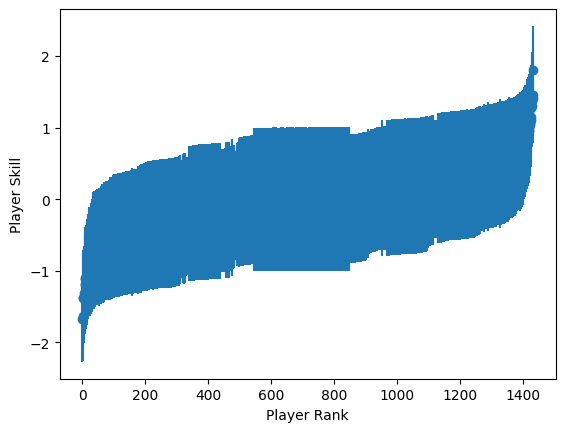

In [ ]:
# mean_skills, logstd_skills = # TODO.  Hint: You don't need to do simple Monte Carlo here.
# Hint: You should use .detach() before you do anything with the params tensors
mean_skills, logstd_skills = params[0].detach(), params[1].detach()
order = torch.argsort(mean_skills)

plt.xlabel("Player Rank")
plt.ylabel("Player Skill")
plt.errorbar(range(num_players),  mean_skills[order],  yerr=torch.exp(logstd_skills)[order], fmt='o')
plt.show()

**e) [1pts]** List the names of the 10 players with the highest mean skill under the variational model.

In [ ]:
mean_skills = params[0]
sorted_indices = torch.argsort(mean_skills, descending=True)
top10 = sorted_indices[:10]

print("Top 10 Players with Highest Mean Skill:")
for i, name in enumerate(names[top10]):
    print(f"{i+1}.{name[0]}")


Top 10 Players with Highest Mean Skill:
1.doraemon61
2.smartduckduckcow
3.projetoxadrez
4.mrzoom47
5.chesswithmom
6.lance5500
7.lzchips
8.chess-brahs
9.cdvh
10.chiggen


**f) [3pt]** Plot samples from the joint posterior over the skills of 'lelik3310' and 'thebestofthebad'. Based on your samples, describe in a sentence the relationship between the skills of the players. (Is one better than the other? Are they approximately even?)

['lelik3310']
['thebestofthebad']


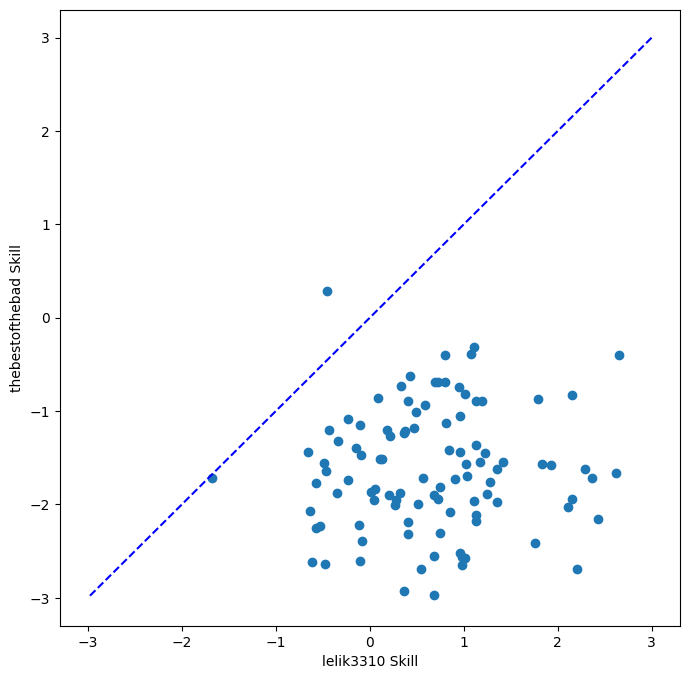

In [ ]:
random.seed(414)
lelik3310_ix = np.where(names == "lelik3310")[0][0]
thebestofthebad_ix = np.where(names == "thebestofthebad")[0][0]

print(names[lelik3310_ix])
print(names[thebestofthebad_ix])
fig = plt.figure(figsize=(8,8), facecolor='white')

# Label each with "<player> Skill"
plt.xlabel("lelik3310 Skill")
plt.ylabel("thebestofthebad Skill")
plt.plot([3, -3], [3, -3], 'b--') # Line of equal skill
samples = diag_gaussian_samples(mean_skills, logstd_skills, 100)
lelik_samples = samples[:,lelik3310_ix].detach().numpy()
bestofbad_samples = samples[:,thebestofthebad_ix].detach().numpy()
plt.scatter(lelik_samples, bestofbad_samples)

**g) [6pts]** Derive the exact probability under a factorized Gaussian over two players’ skills that one has higher skill than the other, as a function of the two means and variances over their skills. Express your answer in terms of the cumulative distribution function of a one-dimensional Gaussian random variable.

- Hint 1: Use a linear change of variables $y_A, y_B = z_A − z_B , z_B$. What does the line of equal skill look like after this transformation?
- Hint 2: If $X \sim \mathcal N (\mu, \Sigma)$, then $AX \sim \mathcal N (A\mu, A\Sigma A^\top)$ where $A$ is a linear transformation.
- Hint 3: Marginalization in Gaussians is easy: if $X \sim \mathcal N (\mu, \Sigma)$, then the $i$th element of $X$ has a
marginal distribution $X_i \sim \mathcal N (\mu_i , \Sigma_{ii})$.

please see the written pdf file.



**h) [4pts]** Compute the probability under your approximate posterior that lelik3310 has higher skill than thebestofthebad. Compute this quantity exactly using the formula you just derived above, and also estimate it using simple Monte Carlo with 10000 examples.

Hint:  You might want to use `Normal(0,1).cdf()` for the exact formula.

In [ ]:
# # TODO
def prob_A_superior_B(N, A_ix, B_ix):
    mean_A, log_std_A = mean_skills[A_ix],  logstd_skills[A_ix]
    mean_B, log_std_B = mean_skills[B_ix],  logstd_skills[B_ix]

    std_A = torch.exp(log_std_A)
    std_B = torch.exp(log_std_B)

    diff_mean = mean_B - mean_A
    diff_std = torch.sqrt(std_A**2 + std_B**2)

    #formula
    normal_dist = Normal(0, 1)
    formula_est = 1 - normal_dist.cdf(diff_mean / diff_std)

    # Monte Carlo
    samples_diff = Normal(diff_mean, diff_std).sample(sample_shape=(N,))
    mc_samples_A = Normal(mean_A,std_A).sample([N])
    mc_samples_B = Normal(mean_B,std_B).sample([N])
    mc_est = torch.mean((mc_samples_A > mc_samples_B).float())
    return formula_est, mc_est
formula_est, mc_est = prob_A_superior_B(10000, lelik3310_ix, thebestofthebad_ix)
print(f"Exact CDF Estimate: {formula_est}")
print(f"Simple MC Estimate: {mc_est}")

Exact CDF Estimate: 0.9877780675888062
Simple MC Estimate: 0.9886000156402588


**i) [3pts]** Compute the probability that lelik3310 is better than the player with the 5th lowest mean skill. Compute this quantity exactly, and then estimate it using simple Monte Carlo with 10000 examples.


In [ ]:
# TODO
order = torch.argsort(mean_skills)
fifth_worst_ix = order[4]

formula_est, mc_est = prob_A_superior_B(10000, lelik3310_ix, fifth_worst_ix)
print(f"Exact CDF Estimate: {formula_est}")
print(f"Simple MC Estimate: {mc_est}")


Exact CDF Estimate: 0.9720855355262756
Simple MC Estimate: 0.9725000262260437


**j) [4pts]** Imagine that we knew ahead of time that we were examining the skills of top chess players, and so changed our prior on all players to Normal(10, 1) and re-ran our approximate inference from scratch. Would that change the answer of either of the previous 2 questions, in expectation?



Adjusting the prior distribution of all players to a normal distribution with a mean of 10 and a standard deviation of 1, from an initial normal distribution with a mean of 0 and a standard deviation of 1, would not alter the outcomes of the prior two questions. This is because, as demonstrated in the derivation, the calculations fundamentally rely on the difference in means, which appears in the cumulative distribution function (CDF) calculation. Taking a broader view, while this change would uniformly shift all priors upward, the comparative analyses remain unaffected. The ranking and relative differences between players are preserved; it's merely that the average is now positioned at 10 instead of zero. This suggests a potential need to adjust the data by subtracting the mean, especially if we aim to interpret or compare these priors in a context where the baseline or average performance is significant.


**k) [4pts]** Based on all the plots and results in this assignment and HW2, which approximate inference method do you suspect is producing a better overall approximation to the true posterior over all skills conditioned on all games?  Give a short explanation.

Based on the graphs from Homework 2 and this assignment, Stochastic Variational Inference (SVI) appears to offer the closest approximation to the true posterior distribution. In comparison, alternative methods displayed slower convergence rates and more variability in the posterior skill rankings. This indicates that SVI is particularly advantageous for larger datasets, prioritizing computational efficiency over absolute precision. Additionally, according to supplementary readings, Markov Chain Monte Carlo (MCMC) methods are more appropriate for smaller datasets where achieving precise results is crucial, and computational expenses are a secondary concern.

# [50pts] Question 2: Expectation-Maximization (EM) algorithm

In [ ]:
%matplotlib inline
import scipy
import numpy as np
import itertools
import matplotlib.pyplot as plt

## 2.1 [8pts] Generating the Data

**a) [5pts]** First, we will generate some data for this problem. Set the number of points $N=400$, their dimension $D=2$, and the number of clusters $K=2$, and generate data from the distribution $p(x|z=k) = N(\mu_k, \Sigma_k)$.
  Sample $200$ data points for $k=1$ and 200 for $k=2$, with

  $$
    \mu_1=
    \begin{bmatrix}
      0.1 \\
      0.1
    \end{bmatrix}
    \ \text{,}\
    \mu_2=
    \begin{bmatrix}
      6.0 \\
      0.1
    \end{bmatrix}
    \ \text{ and }\
    \Sigma_1=\Sigma_2=
    \begin{bmatrix}
      10       & 7 \\
      7 & 10
    \end{bmatrix}
  $$
  Here, $N=400$. If you generate the data, you already know which sample comes from which class. Complete the following statements and run to generate.

  Hint: you can use `np.random.multivariate_normal`.

In [ ]:
num_samples = 200
cov = np.array([[10, 7], [7, 10]])
mean_1 = np.array([0.1, 0.1])
mean_2 = np.array([6.0, 0.1])

x_class1 = np.random.multivariate_normal(mean_1, cov, num_samples)
x_class2 = np.random.multivariate_normal(mean_2, cov, num_samples)
xy_class1 = np.hstack((x_class1, np.zeros((num_samples, 1))))
xy_class2 = np.hstack((x_class2, np.zeros((num_samples, 1))))

data_full = np.vstack((xy_class1, xy_class2))
np.random.shuffle(data_full)
data = data_full[:, :2]
labels = data_full[:, 2]


**b) [3pts]** Make a scatter plot of the data points showing the true cluster assignment of each point using different color codes and shape (x for first class and circles for second class):

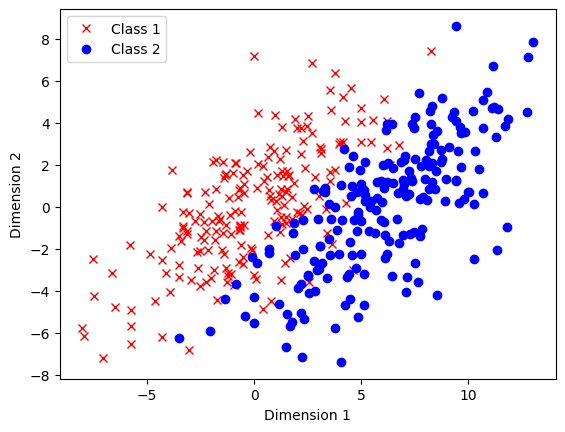

In [ ]:
plt.plot(x_class1[:, 0], x_class1[:, 1], 'rx', label='Class 1') # first class, x shape
plt.plot(x_class2[:, 0], x_class2[:, 1], 'bo', label='Class 2')  # second class, circle shape

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

## 2.2 [14pts] Implement and Run K-Means algorithm

Now, we assume that the true class labels are not known. Implement the k-means algorithm for this problem.
  Write two functions: `km_assignment_step`, and `km_refitting_step` as given in the lecture (Here, `km_` means k-means).
  Identify the correct arguments, and the order to run them. Initialize the algorithm with
  $$
    \hat{\mu}_1=
    \begin{bmatrix}
      0.0 \\
      0.0
    \end{bmatrix}
    \ \text{,}\
    \hat{\mu}_2=
    \begin{bmatrix}
      1.0 \\
      1.0
    \end{bmatrix}
  $$
  and run it until convergence.
  Show the resulting cluster assignments on a scatter plot either using different color codes or shape or both.
  Also plot the cost (distortion in lecture slides) vs. the number of iterations. Report your misclassification error.

**a) [3pts]** Complete the `cost` function.

In [ ]:
def cost(data, R, Mu):
    """ Compute the K-Means cost function

    Args:
        data: an NxD matrix for the data points
        Mu: a DxK matrix for the cluster means locations
        R: an NxK matrix of responsibilities (assignments)

    Returns:
        J: the K-Means cost
    """

    N, D = data.shape # TODO
    K = Mu.shape[1] # TODO
    J = 0

    #iterating over each cluster
    for k in range(K):
      sqred_distance = np.sum((data - Mu[k, :]) **2, axis = 1)
      J += np.sum(R[:, k]* sqred_distance)

    return J

**b) [4pts]** K-Means assignment step.

In [ ]:
def km_assignment_step(data, Mu):
    """ Compute K-Means assignment step

    Args:
        data: an NxD matrix for the data points
        Mu: a DxK matrix for the cluster means locations

    Returns:
        R_new: an NxK matrix of responsibilities
    """

    # N, D = # TODO: Number of datapoints and dimension of datapoint
    # K = # number of clusters
    # r = ... # TODO
    # # TODO assign all r[:, k]

    # arg_min = ... # TODO: argmax/argmin along dimension 1
    # R_new = ... # TODO: Set to zeros/ones with shape (N, K)
    # R_new[..., ...] = 1 # TODO Assign to 1

    N, D = data.shape
    K = Mu.shape[1]
    # Calculate the distances between each data point and each centroid
    distances = np.zeros((N, K))
    for k in range(K):
        distances[:, k] = np.linalg.norm(data - Mu[k], axis=1)

    # Assign each data point to the closest centroid
    closest_Mu = np.argmin(distances, axis=1)

    # Create the responsibilities matrix as zeros
    R_new = np.zeros((N, K))

    # Set the corresponding entry to 1 for the closest centroid
    R_new[np.arange(N), closest_Mu] = 1

    return R_new

**c) [3pts]** K-Means refitting step.

In [ ]:
def km_refitting_step(data, R, Mu):
    """ Compute K-Means refitting step.

    Args:
        data: an NxD matrix for the data points
        R: an NxK matrix of responsibilities
        Mu: a DxK matrix for the cluster means locations

    Returns:
        Mu_new: a DxK matrix for the new cluster means locations
    """

    N, D = data.shape # TODO: number of datapoints and dimension of datapoint
    K = Mu.shape[1] # TODO: number of clusters

    Mu_new = np.zeros((K, D)) # TODO
    for k in range(K):
      data_pt = data[R[:, k] == 1]

      if len(data_pt) > 0:
        Mu_new[k] = np.mean(data_pt, axis = 0)
      else:
        Mu_new[k] = np.random.rand(D)
    return Mu_new

**d) [3pts]** Run this cell to call the K-Means algorithm.

In [ ]:
N, D = data.shape
K = 2
max_iter = 9
class_init = np.random.randint(0, K, N)  # Randomly assign data points to 0 or 1, for K=2 clusters
R = np.zeros((N, K))

Mu = np.zeros([D, K])
Mu[:, 1] = 1.
R.T.dot(data), np.sum(R, axis=0)

for it in range(max_iter):
    R = km_assignment_step(data, Mu)
    Mu = km_refitting_step(data, R, Mu)
    print(it, cost(data, R, Mu))

class_1 = data[np.where(R[:, 0] == 1)]
class_2 = data[np.where(R[:, 1] == 1)]

0 11230.31241690049
1 6168.868639286923
2 5390.445928173326
3 5243.169401148888
4 5211.916985846032
5 5202.874943298642
6 5202.539924868155
7 5202.264175981653
8 5202.264175981653


**e) [1pt]** Make a scatterplot for the data points showing the K-Means cluster assignments of each point.


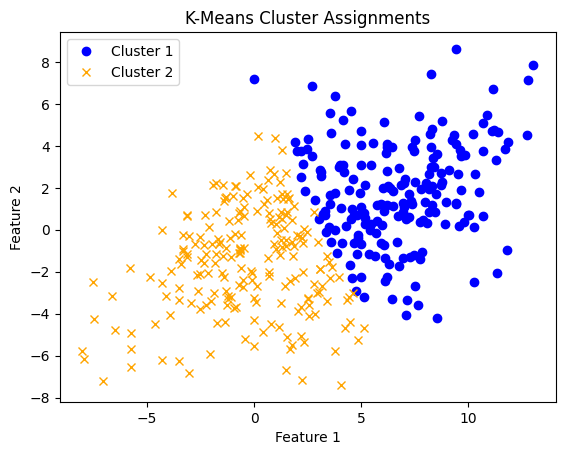

In [ ]:
# plt.plot(class_1[:0], class_1[:,1], linestlye = 'none', color = 'b', marker = 'x') # first class, x shape
# plt.plot(class_2[:0], class_2[:,1], linestlye = 'none', color = 'b', marker = 'x')  # second class, circle shape

cluster_assignments = np.argmax(R, axis=1)

colors = ['blue', 'orange']
markers = ['o', 'x']

# Plot data points for each cluster
for k in range(K):
    cluster_data = data[cluster_assignments == k]
    plt.plot(cluster_data[:, 0], cluster_data[:, 1], color=colors[k], linestyle='None', marker=markers[k], label=f'Cluster {k+1}')

plt.legend()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('K-Means Cluster Assignments')
plt.show()


## 2.3 [19pts] Implement EM algorithm for Gaussian mixtures

Next, implement the EM algorithm for Gaussian mixtures. Write three functions: `log_likelihood`, `gm_e_step`, and `gm_m_step` as given in the lecture.
  - Identify the correct arguments, and the order to run them.
  - Initialize the algorithm with the same initialization as in Q2.1 for the means, and with $\hat\Sigma_1=\hat\Sigma_2=I$, and $\hat\pi_1=\hat\pi_2$.
    
Run the algorithm until convergence and show the resulting cluster assignments on a scatter plot either using different color codes or shape or both. Also plot the log-likelihood vs. the number of iterations. Report your misclassification error.

In [ ]:
def normal_density(x, mu, Sigma):
    return np.exp(-.5 * np.dot(x - mu, np.linalg.solve(Sigma, x - mu))) \
        / np.sqrt(np.linalg.det(2 * np.pi * Sigma))

**a) [5pts]** Log-Likelihood.

In [ ]:
from scipy.stats import multivariate_normal
def log_likelihood(data, Mu, Sigma, Pi):
    """ Compute log likelihood on the data given the Gaussian Mixture Parameters.

    Args:
        data: an NxD matrix for the data points
        Mu: a DxK matrix for the means of the K Gaussian Mixtures
        Sigma: a list of size K with each element being DxD covariance matrix
        Pi: a vector of size K for the mixing coefficients

    Returns:
        L: a scalar denoting the log likelihood of the data given the Gaussian Mixture
    """

    N, D = data.shape  # TODO Number of datapoints and dimension of datapoint
    K = Mu.shape[1] # TODO number of mixtures
    L, T = 0., 0.
    # TODO: given n, k, compute the likelihood from the k-th Gaussian weighted by the mixing coefficients
    for n in range(N):
        p_xn = 0.
        for k in range(K):
            p_xn_k = multivariate_normal.pdf(data[n], mean=Mu[:, k], cov=Sigma[k])
            p_xn += Pi[k] * p_xn_k
        L += np.log(p_xn)
    return L

**b) [5pts]** Gaussian Mixture Expectation Step.

In [ ]:
def gm_e_step(data, Mu, Sigma, Pi):
    """ Gaussian Mixture Expectation Step.

    Args:
        data: an NxD matrix for the data points
        Mu: a DxK matrix for the means of the K Gaussian Mixtures
        Sigma: a list of size K with each element being DxD covariance matrix
        Pi: a vector of size K for the mixing coefficients

    Returns:
        Gamma: an NxK matrix of responsibilities
    """

    N, D = data.shape # TODO Number of datapoints and dimension of datapoint
    K = Mu.shape[1] # TODO number of mixtures
    Gamma = np.zeros((N,K)) # TODO zeros of shape (N,K), matrix of responsibilities

    # TODO: given n, k, normalize by sum across second dimension (mixtures)
    for k in range(K):
      Gamma[:, k] = Pi[k] * multivariate_normal.pdf(data, mean=Mu[:, k], cov=Sigma[k])
    Gamma /= Gamma.sum(axis=1, keepdims=True)
    return Gamma

**c) [5pts]** Gaussian Mixture Maximization Step.

In [ ]:
def gm_m_step(data, Gamma):
    """ Gaussian Mixture Maximization Step.

    Args:
        data: an NxD matrix for the data points
        Gamma: an NxK matrix of responsibilities

    Returns:
        Mu: a DxK matrix for the means of the K Gaussian Mixtures
        Sigma: a list of size K with each element being DxD covariance matrix
        Pi: a vector of size K for the mixing coefficients
    """

    N, D =  data.shape # TODO Number of datapoints and dimension of datapoint
    K = Gamma.shape[1]  # TODO number of mixtures
    Nk = Gamma.sum(axis = 0) # TODO Sum along first axis
    Mu = data.T @ Gamma / Nk # TODO
    Sigma = [np.zeros((D, D)) for _ in range(K)] # TODO

    # TODO: fill in Sigma[k] for each k
    for k in range(K):
        data_centered = data - Mu[:, k].T
        gamma_diag = np.diag(Gamma[:, k])
        Sigma[k] = data_centered.T @ gamma_diag @ data_centered / Nk[k]
    Pi = Nk / N # TODO
    return Mu, Sigma, Pi

**d) [3pts]** Run this cell to call the Gaussian Mixture EM algorithm.

In [ ]:
N, D = data.shape# TODO
K = 2 # TODO
Mu = np.zeros([D, K])
Mu[:, 1] = 1.
Sigma = [np.eye(2), np.eye(2)]
Pi = np.ones(K) / K
Gamma = np.zeros([N, K]) # Gamma is the matrix of responsibilities

max_iter  = 200

for it in range(max_iter):
    Gamma = gm_e_step(data, Mu, Sigma, Pi) # TODO
    Mu, Sigma, Pi =  gm_m_step(data, Gamma) # TODO

class_assignments = np.argmax(Gamma, axis=1)
class_1 = data[class_assignments == 0]# TODO
class_2 = data[class_assignments == 1]# TODO

**e) [1pt]** Make a scatterplot for the data points showing the Gaussian Mixture cluster assignments of each point

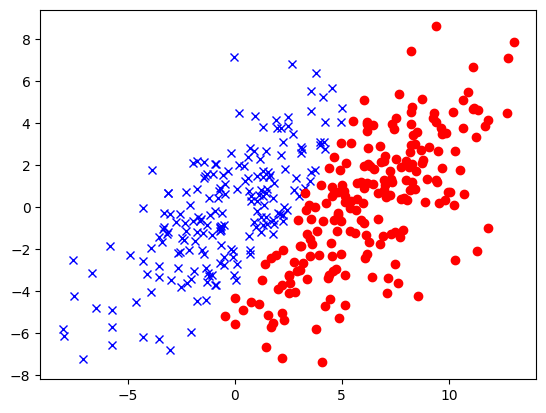

In [ ]:
plt.plot(class_1[:, 0], class_1[:, 1], linestyle='none', color = 'b', marker = "x") # TODO first class, x shape
plt.plot(class_2[:, 0], class_2[:, 1], linestyle='none', color = 'r', marker = "o") # TODO second class, circle shape



## 2.4 [9pts] Comment on findings + additional experiments

Comment on the results:

* Compare the performance of k-Means and EM based on the resulting cluster assignments. [2pts]
* Compare the performance of k-Means and EM based on their convergence rate. What is the bottleneck for which method? [2pts]
* Experiment with 5 different data realizations (generate new data), run your algorithms, and summarize your findings. Does the algorithm performance depend on different realizations of data? [3pts]
* Comment on what might happen as you increase the number $K$ of clusters. [1pts]



(a)
The scatterplots indicate that the Expectation-Maximization (EM) algorithm surpassed the K-Means algorithm in achieving more accurate cluster assignments. A direct comparison between the true cluster assignments and those derived from both K-Means and Gaussian Mixture EM algorithms shows that EM's results closely match the actual assignments, whereas K-Means exhibits notable discrepancies. The EM algorithm's probabilistic approach to assigning data points to clusters—considering varying shapes, sizes, and densities—contributes to its effectiveness, especially with data stemming from a Gaussian mixture model. This capability allows EM to more precisely reflect the data's structure, as demonstrated by the scatterplots and error rates. However, it's crucial to recognize that algorithm performance can depend on initialization, and while EM excelled in this context, outcomes might differ under other conditions or data sets due to potential local minimum traps.

\\
(b)

Comparing k-Means and Expectation-Maximization (EM) in terms of convergence reveals that k-Means often converges quicker due to its simpler point-to-nearest-cluster assignment process, making it efficient for large datasets. However, its sensitivity to initial conditions can lead to varying quality in clustering outcomes, necessitating multiple runs with different initializations to find an optimal solution. EM, though typically slower because of its iterative probabilistic assignments and adjustments of cluster parameters, excels in accurately handling diverse cluster shapes, sizes, and densities. The primary limitation of EM lies in its higher computational demand, especially with extensive data or complex models, posing scalability challenges. Therefore, while k-Means offers speed and is practical for straightforward applications, EM provides depth and precision at the cost of computational intensity, making the choice between them dependent on the dataset's nature and clustering requirements.

\\
(c)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


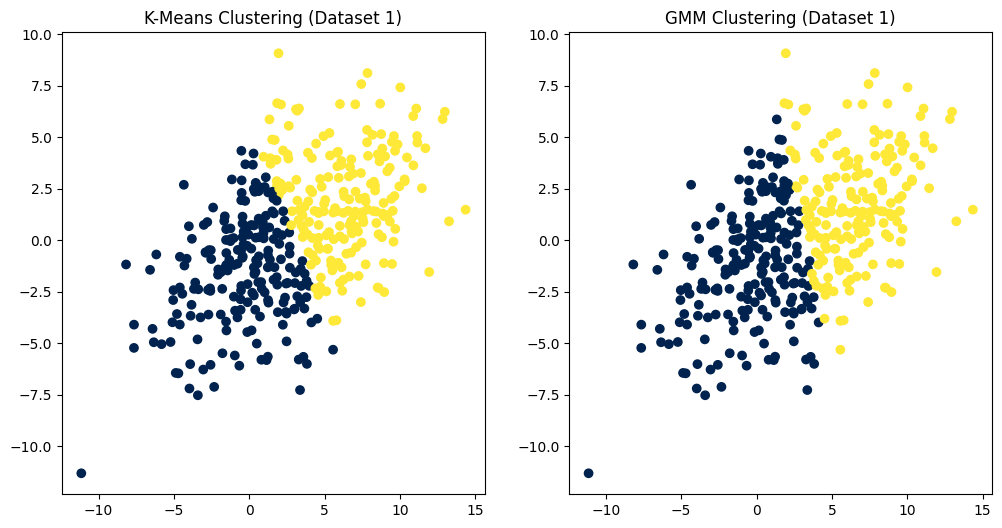

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


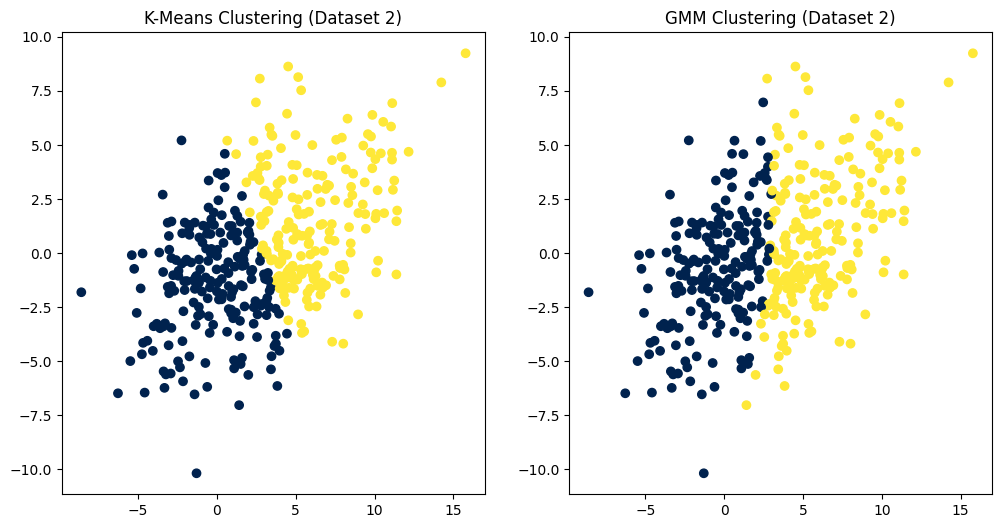

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


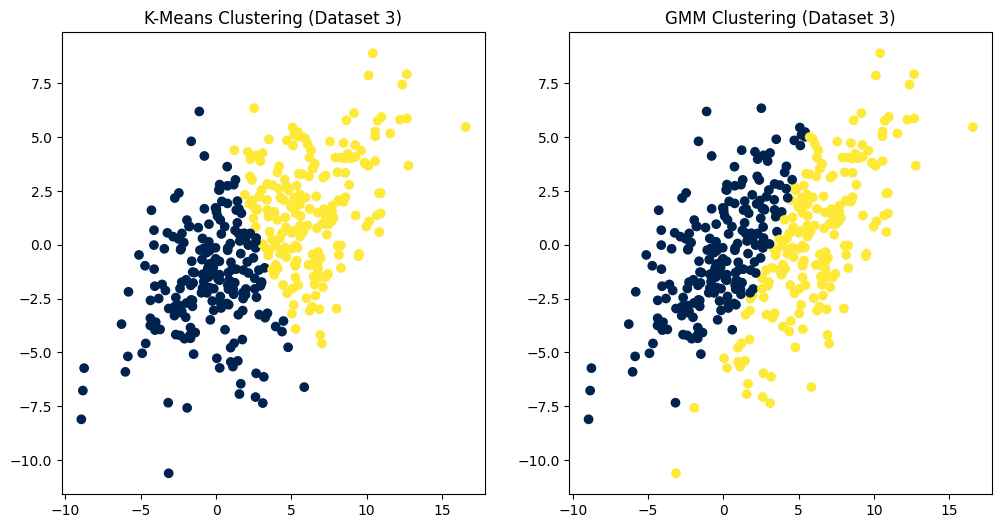

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


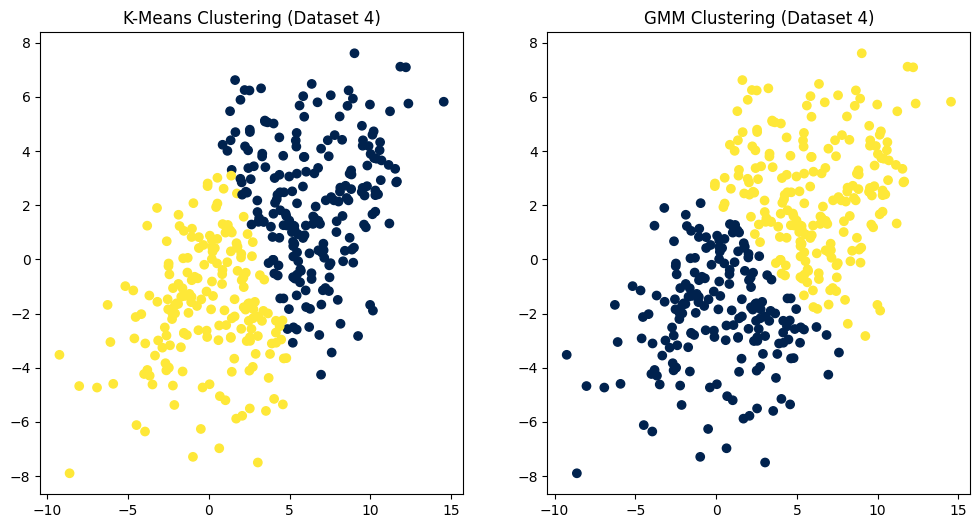

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


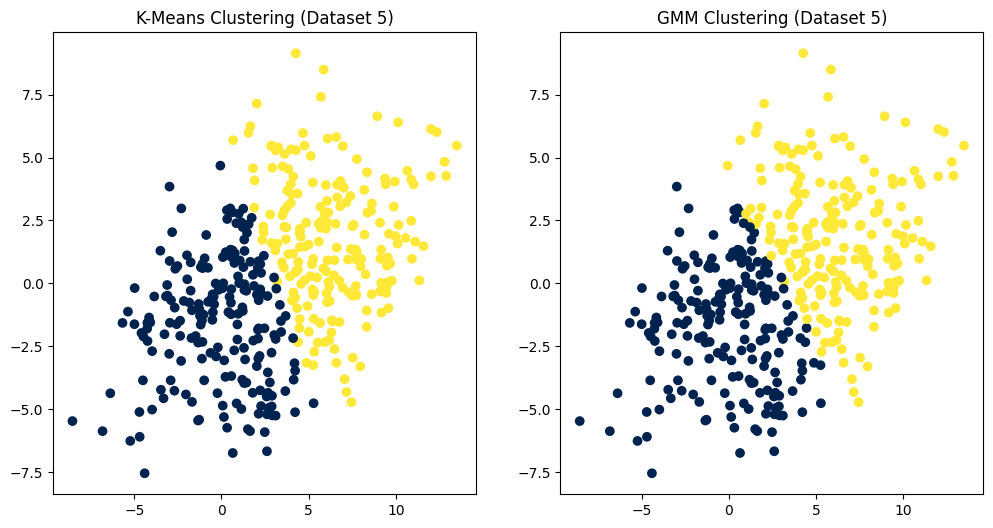

In [ ]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

N = 400
D, K = 2, 2

cov = np.array([[10, 7], [7, 10]])

def generate_data(N, cov):
    x_class1 = np.random.multivariate_normal([0.1, 0.1], cov, N//2)
    x_class2 = np.random.multivariate_normal([6.0, 0.1], cov, N//2)
    return np.vstack((x_class1, x_class2))

# Main loop simplified
for i in range(1, 6):
    data = generate_data(N, cov)

    # KMeans
    kmeans_labels = KMeans(n_clusters=K, random_state=0).fit_predict(data)
    # GMM
    gmm_labels = GaussianMixture(n_components=K, random_state=0).fit_predict(data)

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.scatter(data[:, 0], data[:, 1], c=kmeans_labels, cmap='cividis')
    plt.title(f"K-Means Clustering (Dataset {i})")

    plt.subplot(122)
    plt.scatter(data[:, 0], data[:, 1], c=gmm_labels, cmap='cividis')
    plt.title(f"GMM Clustering (Dataset {i})")
    plt.show()


The scatter plots compare the clustering results of K-Means and GMM algorithms across five data sets, showcasing how each algorithm responds to data variability. The K-Means clustering shows relatively consistent boundaries despite data changes, with minor shifts such as label swaps. In contrast, GMM's EM-based approach exhibits more fluctuation in cluster assignments, indicating a higher sensitivity to data variations and noise. This variability underscores the impact of initial data point assignments to clusters, especially when dealing with ambiguous data separation. Both algorithms' performance is notably affected by each data set's specific characteristics, highlighting the importance of considering data variability in clustering analyses.

# [0pts] Question 3: Please fill out the course evaluations.

Did/will you complete the course evaluations? Hint: We would appreciate your feedback.